In [1]:
import xarray as xr
import fsspec
from google.cloud import storage
import os
import numpy as np


os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/adamhunter/Documents/school projs/firenet/data/credentials/firenet-99-reader.json'

moisture eg: ABI-L2-CMIPC/2023/003/15/OR_ABI-L2-CMIPC-M6C02_G18_s20230031551174_e20230031553547_c20230031554040.nc

Temp eg: ABI-L2-LSTC/2022/313/23/OR_ABI-L2-LSTC-M6_G18_s20223132301173_e20223132303546_c20223132305195.nc

fire mask eg: ABI-L2-FDCC/2023/001/00/OR_ABI-L2-FDCC-M6_G18_s20230010056170_e20230010058543_c20230010059116.nc

fire mask full: ABI-L2-FDCF/2022/286/16/OR_ABI-L2-FDCF-M6_G18_s20222861610210_e20222861619518_c20222861620026.nc

fire mask with fires: ABI-L2-FDCC/2023/221/23/OR_ABI-L2-FDCC-M6_G18_s20232212301175_e20232212303548_c20232212304119.nc

In [9]:
blob_name = 'ABI-L2-FDCC/2023/352/17/OR_ABI-L2-FDCC-M6_G16_s20233521726173_e20233521728546_c20233521729155.nc'
# Use fsspec to create a file system
fs = fsspec.filesystem('gcs', token=os.environ['GOOGLE_APPLICATION_CREDENTIALS'])

# Open the file directly into memory with xarray
f = fs.open(f'gcp-public-data-goes-16/{blob_name}')
ds = xr.open_dataset(f, engine='h5netcdf')

In [10]:
print(ds.data_vars)


Data variables:
    Area                                              (y, x) float32 ...
    Temp                                              (y, x) float32 ...
    Mask                                              (y, x) float32 ...
    Power                                             (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat                    float32 ...
    nominal_satellite_subpoint_lon                    float32 ...
    nominal_satellite_height                          float32 ...
    geospatial_lat_lon_extent                         float32 ...
    sunglint

In [11]:
mask = ds['x']

print('Min:', mask.min().values)
print('Max:', mask.max().values)
print('Mean:', mask.mean().values)
print('Standard deviation:', mask.std().values)

Min: -0.10133200138807297
Max: 0.03861200053142966
Mean: -0.031360000428321655
Standard deviation: 0.04041451616444654


In [12]:
print(ds.variables['goes_imager_projection'])

<xarray.Variable ()>
[1 values with dtype=int32]
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    sweep_angle_axis:                x


In [13]:
def calculate_degrees(file_id):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.attrs['longitude_of_projection_origin']
    H = projection_info.attrs['perspective_point_height'] + projection_info.attrs['semi_major_axis']
    r_eq = projection_info.attrs['semi_major_axis']
    r_pol = projection_info.attrs['semi_minor_axis']    
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon


In [ ]:
import xarray as xr
band_data = ds['DQF'].values
zero_indices = np.where(band_data == 0)
lat, lon = calculate_degrees(ds)
zero_lat_lon = lat[zero_indices], lon[zero_indices]
import geojson
features = []
for lat, lon in zip(*zero_lat_lon):
    point = geojson.Point((lon, lat))
    features.append(geojson.Feature(geometry=point))

feature_collection = geojson.FeatureCollection(features)





In [14]:
feature_collection

NameError: name 'feature_collection' is not defined

In [15]:
import folium

# Create a folium map centered at the first feature's coordinates
first_feature = feature_collection['features'][0]
first_coordinates = first_feature['geometry']['coordinates']
map = folium.Map(location=[first_coordinates[1], first_coordinates[0]], zoom_start=5)

# Add each feature as a marker to the map
for feature in feature_collection['features']:
    coordinates = feature['geometry']['coordinates']
    folium.Marker([coordinates[1], coordinates[0]]).add_to(map)

map


NameError: name 'feature_collection' is not defined

In [16]:
from datetime import datetime, timedelta
import pandas as pd
from google.cloud import storage
import fsspec
import xarray as xr

In [17]:
def get_blob_names(attime=datetime.utcnow(), within=pd.to_timedelta("1H"), bucket_name='gcp-public-data-goes-18'):
    if isinstance(attime, str):
        attime = pd.to_datetime(attime)
    if isinstance(within, str):
        within = pd.to_timedelta(within)

    # Parameter Setup
    start = attime - within
    end = attime + within

    # Set up Google Cloud Storage client
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)

    # Create a range of directories to check. The GOES bucket is
    # organized by hour of day.
    blob_names = []
    for hour in range(start.hour, end.hour + 1):
        prefix = f'ABI-L2-CMIPC/{start.year}/{start.timetuple().tm_yday:03d}/{hour:02d}/'
        blobs = bucket.list_blobs(prefix=prefix)
        blob_names.extend([blob.name for blob in blobs])

    return blob_names

def select_blobs(blob_names):
    # Sort blob names by timestamp
    blob_names.sort(key=lambda name: name.split('_')[3][1:], reverse=True)  # Extract timestamp after 's'

    # Extract band numbers from blob names
    band_numbers = [int(name.split('_')[1][-2:]) for name in blob_names]

    # Get unique band numbers and sort them
    expected_band_order = sorted(set(band_numbers))

    # Find the first continuous sequence that matches the expected band order
    for i in range(len(blob_names) - len(expected_band_order) + 1):
        selected = blob_names[i:i+len(expected_band_order)]
        band_order = [int(name.split('_')[1][-2:]) for name in selected]
        if band_order == expected_band_order:
            break
    else:
        raise Exception("No continuous sequence found that matches the expected band order")

    return selected

def get_datasets(blob_names, bucket_name='gcp-public-data-goes-18'):
    # Open each blob as an xarray Dataset and store it in the dictionary under the corresponding channel identifier
    datasets = {}
    for name in blob_names:
        channel_id = name.split('_')[1]
        f = fs.open(f'{bucket_name}/{name}')
        ds = xr.open_dataset(f, engine='h5netcdf')
        datasets[channel_id] = ds

    return datasets

In [5]:
names = get_blob_names()
names

['ABI-L2-CMIPC/2023/344/13/OR_ABI-L2-CMIPC-M6C01_G18_s20233441301191_e20233441303563_c20233441304027.nc',
 'ABI-L2-CMIPC/2023/344/13/OR_ABI-L2-CMIPC-M6C01_G18_s20233441306191_e20233441308563_c20233441309026.nc',
 'ABI-L2-CMIPC/2023/344/13/OR_ABI-L2-CMIPC-M6C01_G18_s20233441311191_e20233441313564_c20233441314074.nc',
 'ABI-L2-CMIPC/2023/344/13/OR_ABI-L2-CMIPC-M6C01_G18_s20233441316191_e20233441318565_c20233441319029.nc',
 'ABI-L2-CMIPC/2023/344/13/OR_ABI-L2-CMIPC-M6C01_G18_s20233441321191_e20233441323563_c20233441324031.nc',
 'ABI-L2-CMIPC/2023/344/13/OR_ABI-L2-CMIPC-M6C01_G18_s20233441326191_e20233441328564_c20233441329034.nc',
 'ABI-L2-CMIPC/2023/344/13/OR_ABI-L2-CMIPC-M6C01_G18_s20233441331191_e20233441333563_c20233441334023.nc',
 'ABI-L2-CMIPC/2023/344/13/OR_ABI-L2-CMIPC-M6C01_G18_s20233441336191_e20233441338564_c20233441339030.nc',
 'ABI-L2-CMIPC/2023/344/13/OR_ABI-L2-CMIPC-M6C01_G18_s20233441341191_e20233441343564_c20233441344028.nc',
 'ABI-L2-CMIPC/2023/344/13/OR_ABI-L2-CMIPC-M6C

In [6]:
selected = select_blobs(names)
selected

['ABI-L2-CMIPC/2023/344/14/OR_ABI-L2-CMIPC-M6C01_G18_s20233441411191_e20233441413564_c20233441414033.nc',
 'ABI-L2-CMIPC/2023/344/14/OR_ABI-L2-CMIPC-M6C02_G18_s20233441411191_e20233441413564_c20233441414042.nc',
 'ABI-L2-CMIPC/2023/344/14/OR_ABI-L2-CMIPC-M6C03_G18_s20233441411191_e20233441413564_c20233441414023.nc',
 'ABI-L2-CMIPC/2023/344/14/OR_ABI-L2-CMIPC-M6C04_G18_s20233441411191_e20233441413564_c20233441414022.nc',
 'ABI-L2-CMIPC/2023/344/14/OR_ABI-L2-CMIPC-M6C05_G18_s20233441411191_e20233441413564_c20233441414032.nc',
 'ABI-L2-CMIPC/2023/344/14/OR_ABI-L2-CMIPC-M6C06_G18_s20233441411191_e20233441413569_c20233441414043.nc',
 'ABI-L2-CMIPC/2023/344/14/OR_ABI-L2-CMIPC-M6C07_G18_s20233441411191_e20233441413576_c20233441414065.nc',
 'ABI-L2-CMIPC/2023/344/14/OR_ABI-L2-CMIPC-M6C08_G18_s20233441411191_e20233441413564_c20233441414087.nc',
 'ABI-L2-CMIPC/2023/344/14/OR_ABI-L2-CMIPC-M6C09_G18_s20233441411191_e20233441413570_c20233441414053.nc',
 'ABI-L2-CMIPC/2023/344/14/OR_ABI-L2-CMIPC-M6C

In [12]:
from tqdm.notebook import tqdm
# Use fsspec to create a file system
fs = fsspec.filesystem('gcs', token=os.environ['GOOGLE_APPLICATION_CREDENTIALS'])

ds = get_datasets(tqdm(selected, desc="Processing datasets"))
print(ds.keys())
print(len(ds.keys()))

Processing datasets:   0%|          | 0/16 [00:00<?, ?it/s]

dict_keys(['ABI-L2-CMIPC-M6C01', 'ABI-L2-CMIPC-M6C02', 'ABI-L2-CMIPC-M6C03', 'ABI-L2-CMIPC-M6C04', 'ABI-L2-CMIPC-M6C05', 'ABI-L2-CMIPC-M6C06', 'ABI-L2-CMIPC-M6C07', 'ABI-L2-CMIPC-M6C08', 'ABI-L2-CMIPC-M6C09', 'ABI-L2-CMIPC-M6C10', 'ABI-L2-CMIPC-M6C11', 'ABI-L2-CMIPC-M6C12', 'ABI-L2-CMIPC-M6C13', 'ABI-L2-CMIPC-M6C14', 'ABI-L2-CMIPC-M6C15', 'ABI-L2-CMIPC-M6C16'])
16


In [18]:
single = ds['ABI-L2-CMIPC-M6C01']

In [21]:
timestamp = single.t.values


In [22]:
timestamp

numpy.datetime64('2023-12-10T14:12:37.760866944')

Count where DQF is 0: 17


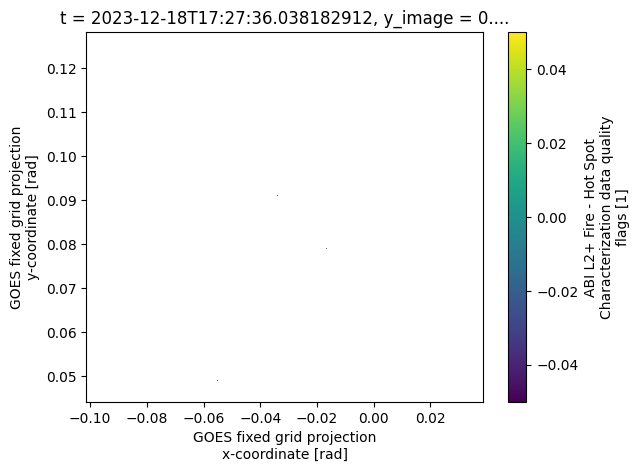

In [20]:
# Plot 'DQF' where dqf = 0
dqf_zero = ds['DQF'] == 0
ds['DQF'].where(dqf_zero).plot()
print("Count where DQF is 0:", dqf_zero.sum().values)

